# 2 - CLEAN AND EXPLORE GAIA DR3
As stated in the README file, the use of this dataset is only to replicate figures propose by other researchers about the distribution of stars in our observable universe. Gaia, unlike the Kepler mission, is not a niche mission bound to a specific goal such as exoplanet discovery (which influenced observational methods and targets), but instead is an effort by the European Space Agency (ESA) to map the Milky Way Galaxy in its entirety.

Here, I tasked myself with attempting to do the following:
1. Get a distribution of star classifications within our observable universe

## 1.) Import Dependencies, Environment

In [1]:
# Jupyter magic
%run ../util/dependencies.py

# personal helper file for exploration
import sys
sys.path.append('../util')
import helper as h

# Load the raw data as dataframe
file_path = '../data/gaiadr3_01_raw.csv'
gaia_df = pd.read_csv(file_path)

# set visual style for plots during exploration
sns.set_palette('rocket')
sns.set_style("darkgrid")
plt.style.use("dark_background")

Using the rocket palette because it looks COOL AS FUQ

## 2.) Basic Exploration

In [2]:
# I used my helper function here after seeing that I would referring to the describe(), info(), and header() functions too often to preview a dataframe for cleaning
h.basic_exploration(gaia_df, 'GAIA DR3 DB')

GAIA DR3 DB

~~~~~~~~~~~~~~~~~
Info
~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
Index: 3000000 entries, 0 to 2999999
Data columns (total 12 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   source_id                 int64  
 1   teff_gspphot              float64
 2   bp_rp                     float64
 3   random_index              int64  
 4   parallax                  float64
 5   parallax_error            float64
 6   parallax_over_error       float64
 7   ruwe                      float64
 8   phot_bp_rp_excess_factor  float64
 9   phot_g_mean_mag           float64
 10  radius_gspphot            float64
 11  mass_flame                float64
dtypes: float64(10), int64(2)
memory usage: 297.5 MB
None

~~~~~~~~~~~~~~~~~
Head
~~~~~~~~~~~~~~~~~
         source_id  teff_gspphot     bp_rp  random_index  parallax  \
0   13301514552192     6623.5117  0.618286       8745044  3.148076   
1  192723772743296     5388.4683  0.833492      1203

A huge hump I am running into with this data deals with classification (of course, the most important part of the analysis of this particular dataset):
1. Stars are **NOT classified** on the Morgan-Keenan (MK) scale in this dataset
2. Effective temperature (**TEFF**) of stars are only avaiable for approximately 41.88% of recorded stars

This is difficult, as even when I have not been able to rely upon stars being classified from the get-go, utilizing the TEFF has been an effective means of classifying these stars myself. Utilizing TEFF is in fact how astronomers determine -in part- how stars are classified under the MK system. For more information, please see the README or Kepler Stellar exploration as a reference on this process.

## 3.) Tackling unidentified stars
### Methodology
Seeing as we do not have the effective temperature of most stars, my plan is as follows:
2. Approximate classifications of all other stars by utilizing a star's BP-RP color feature, and pairing that with it's absolute magnitude (**This is exactly what many published Gaia DR3 population studies do**)
3. Save a star's classification in the gaia_df dataframe, along with the lumonocity class
4. Add a confidence flag based on whether the classification is derived from the teff value or not
5. Analyze the distribution of star classifications with both known teff values and unkown teff values, and compare those values with a table analyzed using only stars with teff values. The importance of this is twofold: ensuring that approximations of star classifications are accurate AND determining if there are biases in star detection methods

0. Pre‑classification Quality Filtering (Added Step)
Before classifying any stars, apply Gaia DR3 quality filters to ensure reliable photometry and parallaxes:
    - parallax_over_error > 5
    - ruwe (Renormalized Unit Weight Error) < 1.4
    - phot_bp_rp_excess_factor within recommended range
    - Remove stars with non‑positive parallax (already completed in query)
    - Compute absolute magnitude only for stars passing these filters
This produces a clean HR diagram and prevents misclassification due to noisy data.
1. For all stars with a known teff value, pair that feature with absolute magnitude to determine their classification.
    - This is the most accurate method of classifying stars without spectroscopy
    - Use Teff bins to determine spectral type (O/B/A/F/G/K/M).
    - Use absolute magnitude to distinguish dwarfs, subgiants, and giants.
    - This prevents misclassifying red giants as cool dwarfs.
2. Approximate classifications of all other stars by utilizing a star's BP–RP color feature, and pair that with its absolute magnitude to Assign Luminosity Class.
    - This is exactly what many published Gaia DR3 population studies do.
    - BP–RP alone cannot distinguish dwarfs from giants.
    - Absolute magnitude provides the vertical separation needed.
    - This step is essential for accurate classification of stars lacking Teff.
3. Save a star's classification in the gaia_df dataframe, along with the luminosity class.
4. Add a confidence flag based on whether the classification is derived from the Teff value or not.
    - High confidence → Teff‑based
    - Medium confidence → BP–RP + good parallax
    - Low confidence → BP–RP + borderline parallax quality
5. Add a classification_source Column (Added Step). This will make downstream filtering and analysis easier. Here are some examples:
    - "teff"
    - "color"
    - "color_low_quality"
6. Analyze the distribution of star classifications with both known Teff values and unknown Teff values, and compare those values with a table analyzed using only stars with Teff values. The importance of this is twofold:
    1. ensuring that approximations of star classifications are accurate
    2. determining if there are biases in star detection methods
7. Validate BP–RP Classification Against Teff‑Based Classification (Added Step) This quantifies the accuracy of my approximation method. For stars that do have Teff:
    - Classify them using Teff
    - Classify them again using BP–RP
    - Compare results (confusion matrix, misclassification rate)
8. Visualize the HR Diagram With Classifications Overlaid (Added Step) This provides a visual sanity check on my classification boundaries. Plot:
    - Teff‑classified stars
    - BP–RP‑classified stars
    - Dwarfs vs giants
8. Document Classification Boundaries and Assumptions (Added Step) Include a Markdown cell describing:
    - Teff bins
    - BP–RP bins
    - Absolute magnitude cuts
    - Quality filters
    - Confidence flag logic



### BP-RP Color
BP-RP is:
- available for nearly all Gaia stars
- tightly correlated with Teff
- the standard proxy used in the literature
- the basis of most Gaia color–Teff calibrations

Pairing BP–RP with absolute magnitude is how we:
- avoid misclassifying red giants as M dwarfs
- avoid confusing reddened stars with cool stars
- place stars correctly on the HR diagram

### 0. Pre-classification quality filtering
1. parallax_over_error > 5 is standard practice for astro-data analysis, to ensure noiseless entries
2. ruwe (Renormalized Unit Weight Error) < 1.4 is standard practice for gaia dr3 studies and papers
3. Gaia documentation gives the following formula the determine if BP/RP photometry is in a safe zone, and therefore is trustworthy
    - 1.0 + 0.015(BP - RP)^2 < C < 1.3 + 0.06(BP - RP)^2
    - C = phot_bp_rp_excess_factor
4. Compute absolute magnitude (abs_mag) of lumonicity of star by:
    - relative_mag + 5log10(parallax / 1000) + 5

In [3]:
# Filter out records of stars with a parallax/error of < 5
# (signal is 5x stronger than noise)
gaia_df = gaia_df[gaia_df['parallax_over_error'] >= 5] #create boolean mask, and keep relevant records

# ruwe is below 1.4
gaia_df = gaia_df[gaia_df['ruwe'] < 1.4]

# BP flux (blue light) and RP flux (red light) contaminated?
bp_rp = gaia_df['bp_rp']
excess = gaia_df['phot_bp_rp_excess_factor']
bp_rp_lower_bound = 1.0 + 0.015 * (bp_rp ** 2)
bp_rp_upper_bound = 1.3 + 0.06 * (bp_rp ** 2)
gaia_df = gaia_df[(excess > bp_rp_lower_bound) & (excess < bp_rp_upper_bound)]

# Compute absolute magnitude of stars with parallax and lumonocity
gaia_df['abs_mag'] = gaia_df['phot_g_mean_mag'] + (5 * np.log10(gaia_df['parallax'] / 1000)) + 5

# verify work
h.basic_exploration(gaia_df, 'Gaia DR3 (Quality Filtered)')


Gaia DR3 (Quality Filtered)

~~~~~~~~~~~~~~~~~
Info
~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
Index: 561656 entries, 0 to 2999999
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   source_id                 561656 non-null  int64  
 1   teff_gspphot              495869 non-null  float64
 2   bp_rp                     561656 non-null  float64
 3   random_index              561656 non-null  int64  
 4   parallax                  561656 non-null  float64
 5   parallax_error            561656 non-null  float64
 6   parallax_over_error       561656 non-null  float64
 7   ruwe                      561656 non-null  float64
 8   phot_bp_rp_excess_factor  561656 non-null  float64
 9   phot_g_mean_mag           561656 non-null  float64
 10  radius_gspphot            495869 non-null  float64
 11  mass_flame                316016 non-null  float64
 12  abs_mag                   561656 n

### 1/2/3/5. Classify stars with TEFF and abs_mag AND classify based on CMD

In [4]:
# Rename columns to match NASA exoplanet archive feature names
gaia_df.rename(columns = {'teff_gspphot' : 'st_teff'}, inplace=True)

# Apply my helper function from util/helper.py
gaia_df['st_spectype'] = gaia_df.apply(h.define_spectype, axis=1)

# Split spectype into different features
gaia_df[['st_class', 'st_classsub', 'st_classlum']] = (
    gaia_df['st_spectype']
    .str.extract(r'([OBAFGKM])(\d|_)?([IV]+|V)?')
)

h.basic_exploration(gaia_df, "Gaia DR3 Classified Stars")

Gaia DR3 Classified Stars

~~~~~~~~~~~~~~~~~
Info
~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
Index: 561656 entries, 0 to 2999999
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   source_id                 561656 non-null  int64  
 1   st_teff                   495869 non-null  float64
 2   bp_rp                     561656 non-null  float64
 3   random_index              561656 non-null  int64  
 4   parallax                  561656 non-null  float64
 5   parallax_error            561656 non-null  float64
 6   parallax_over_error       561656 non-null  float64
 7   ruwe                      561656 non-null  float64
 8   phot_bp_rp_excess_factor  561656 non-null  float64
 9   phot_g_mean_mag           561656 non-null  float64
 10  radius_gspphot            495869 non-null  float64
 11  mass_flame                316016 non-null  float64
 12  abs_mag                   561656 non

### 4. Confidence Flag

In [5]:
# apply confidence flag
gaia_df['confidence_flag'] = gaia_df.apply(h.calc_class_confidence_flag, axis=1)

### 6. Analyze the distribution of star classifications with both known Teff values and unknown Teff values, and compare those values with a table analyzed using only stars with Teff values. The importance of this is twofold:
    1. ensuring that approximations of star classifications are accurate
    2. determining if there are biases in star detection methods


### 7. Validate BP–RP Classification Against Teff‑Based Classification (Added Step) This quantifies the accuracy of my approximation method. For stars that do have Teff:
    - Classify them using Teff
    - Classify them again using BP–RP
    - Compare results (confusion matrix, misclassification rate)

### 8. Visualize the HR Diagram With Classifications Overlaid (Added Step) This provides a visual sanity check on my classification boundaries. Plot:
    - Teff‑classified stars
    - BP–RP‑classified stars
    - Dwarfs vs giants

### 9. Document Classification Boundaries and Assumptions (Added Step) Include a Markdown cell describing:
    - Teff bins
    - BP–RP bins
    - Absolute magnitude cuts
    - Quality filters
    - Confidence flag logic

## 4.) Underepresented low absolute-luminosity types
A big issue I am seeing here is that the classifications of stars do not seem to be distributed according to what other studies have put out (e.g. M -Red Dwarf- stars should account for ~76.5% of observed stars). Based on counts above, K and G star types seem to be grossly overestimated. My theory is that, due to the nature of low-luminocity star types such as M or A (which we should see much more of), these stars are being weeded out in the data-quality filtering (step 0). As such, to better account for these stars, we can limit our analysis to a volume constraint where the stars are more likely to be picked up by nature of them being closer to our planet. As a result, M type stars should account for far more of our analysis. Recall that the filtered stars are a consequence -generally speaking- of high relative luminocity, so limiting our scope to stars with a low-distance will help us achieve this.

In [6]:
# distance of star in parcecs
gaia_df['distance_pc'] = gaia_df.apply(h.calc_distance_pc, axis=1)

# Creat subsets of volume-limited dataframes to accurately represent distributions of
# spectraltypes independent of detection bias towards certain star luminocities
gaia_df_vol_300 = gaia_df[gaia_df['distance_pc'] < 300]
gaia_df_vol_200 = gaia_df_vol_300[gaia_df_vol_300['distance_pc'] < 200]
gaia_df_vol_150 = gaia_df_vol_200[gaia_df_vol_200['distance_pc'] < 150]
gaia_df_vol_100 = gaia_df_vol_150[gaia_df_vol_150['distance_pc'] < 100]
gaia_df_vol_50  = gaia_df_vol_100[gaia_df_vol_100['distance_pc'] < 50]

In [7]:
# Evaluate results of limiting scope to 50 parcecs . . .
h.basic_exploration(gaia_df_vol_50, "Gaia DR3 (Vol Controlled at 50 PC)")

Gaia DR3 (Vol Controlled at 50 PC)

~~~~~~~~~~~~~~~~~
Info
~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
Index: 114 entries, 471 to 2993211
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   source_id                 114 non-null    int64  
 1   st_teff                   43 non-null     float64
 2   bp_rp                     114 non-null    float64
 3   random_index              114 non-null    int64  
 4   parallax                  114 non-null    float64
 5   parallax_error            114 non-null    float64
 6   parallax_over_error       114 non-null    float64
 7   ruwe                      114 non-null    float64
 8   phot_bp_rp_excess_factor  114 non-null    float64
 9   phot_g_mean_mag           114 non-null    float64
 10  radius_gspphot            43 non-null     float64
 11  mass_flame                20 non-null     float64
 12  abs_mag                   114 non-null    

## Analyzed

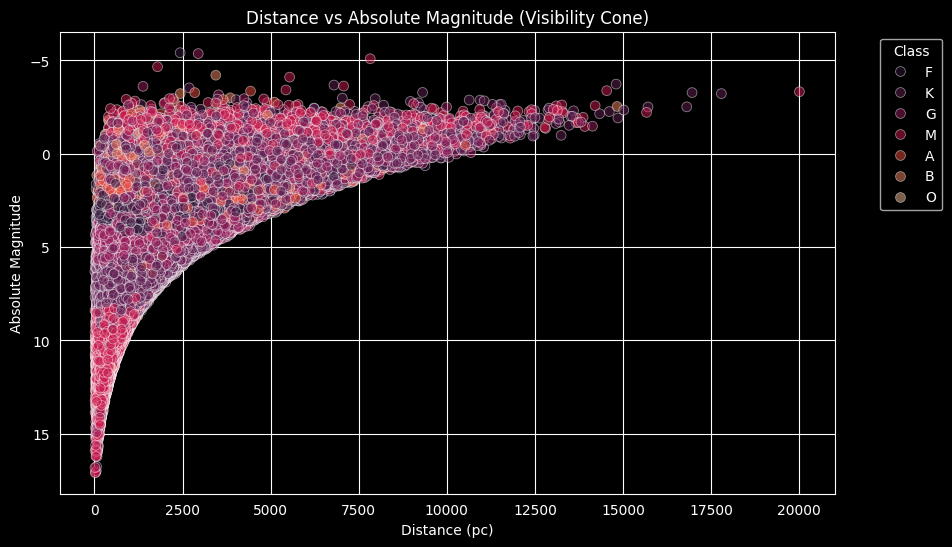

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=gaia_df,
    x='distance_pc',
    y='abs_mag',
    hue='st_class',
    s=50,
    alpha=0.5,
    palette='rocket'
)

plt.gca().invert_yaxis()  # brighter = lower magnitude
plt.xlabel("Distance (pc)")
plt.ylabel("Absolute Magnitude")
plt.title("Distance vs Absolute Magnitude (Visibility Cone)")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
plt.show()
